# Analyse de l'amplitude thermique cumulative en France : Tendances et variations climatiques


Le fichier de données météo utilisé dans cette analyse provient de Météo France et contient des informations météorologiques quotidiennes pour divers postes en France, couvrant une période allant de 1950 à 2023. Les données comprennent des variables telles que la température, les précipitations et la vitesse du vent. L'objectif de cette analyse est de calculer la somme cumulative de l'amplitude thermique journalière pour chaque année, en moyennant d'abord sur toutes les stations, et de ne garder que la valeur de fin de chaque année.

Les données utilisées sont disponibles à l'adresse suivante : https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_64_previous-1950-2023_RR-T-Vent.csv.gz. Ce fichier contient des informations précieuses sur les conditions climatiques en France sur une période de plusieurs décennies, permettant ainsi d'analyser les tendances et les variations climatiques à long terme.


## Méthodologie

La méthodologie utilisée dans cette analyse consiste à appliquer une requête SQL pour calculer l'amplitude thermique journalière moyenne par jour sur toutes les stations, puis à calculer la somme cumulative de cette amplitude pour chaque année. Les données sont ensuite filtrées pour ne garder que la dernière valeur de chaque année. Cette approche permet d'obtenir une vue d'ensemble des tendances climatiques en France sur la période étudiée.


## Analyse et visualisation des résultats

Les résultats de l'analyse sont présentés sous forme de graphique, montrant l'évolution de l'amplitude thermique cumulative annuelle en France sur la période 1950-2023. Le graphique inclut une courbe de lissage sur 5 ans pour mettre en évidence les tendances à long terme.


Les étapes de visualisation incluent le chargement des données dans un dataframe pandas, le calcul des valeurs annuelles et le tracé des courbes à l'aide de matplotlib.


## Conclusion

Cette analyse a permis de mettre en évidence les tendances et les variations climatiques en France sur la période 1950-2023. Les résultats obtenus peuvent être utilisés pour éclairer les décisions relatives à la planification et à la gestion des ressources en fonction des conditions climatiques attendues.

## 🔧 Configuration

In [1]:
# Installation et imports
import duckdb as ddb
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

## 🦆 Chargement du dataset avec Duckdb

In [2]:
# Fonction de chargement complète (basée sur load_file_from_url_lite)
def load_file_from_url_lite(url_dataset="", loader="read_csv_auto", options="", nom_table="loaded_dataset", safe_mode=False):
    ddb.execute("install spatial")
    ddb.execute("load spatial")
    ddb.execute("INSTALL h3 FROM community")
    ddb.execute("LOAD h3")
    ddb.execute("install webbed from community;")
    ddb.execute("load webbed")
    ddb.execute("set force_download=True")
    ddb.execute(f"drop table if exists {nom_table}")   
    
    # Détection automatique du type de fichier
    if 'csv' in url_dataset: 
        loader = "read_csv_auto"
    elif 'tsv' in url_dataset: 
        loader = "read_csv_auto"
    elif 'txt' in url_dataset: 
        loader = "read_csv_auto"
    elif 'parquet' in url_dataset: 
        loader = "read_parquet"
    elif 'json' in url_dataset: 
        loader = "read_json_auto"
    elif 'xls' in url_dataset or 'xlsx' in url_dataset: 
        loader = "st_read"
    elif 'shp' in url_dataset: 
        loader = "st_read"
    elif 'geojson' in url_dataset: 
        loader = "st_read"
    elif 'xml' in url_dataset: 
        loader = "read_xml"
    elif 'html' in url_dataset: 
        loader = "read_html"
    else: 
        raise ValueError(f"Type de fichier non supporté pour {url_dataset}")
    
    if options=="": 
        options = "" 
    if 'csv' in url_dataset and safe_mode==True: 
        options = ", all_varchar=1" 
    if nom_table=="": 
        nom_table = "loaded_dataset"
    
    try:
        status = ddb.sql(f"""
            create or replace table {nom_table} as select *
            from
            {loader}("{url_dataset}" {options})
        """)
        return status
    except Exception as e:
        return f"Erreur au chargement du fichier : {str(e)}"

def run_query(sql):
    return ddb.sql(sql.replace("`"," ")).to_df()

# Chargement des données
load_file_from_url_lite("https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_64_previous-1950-2023_RR-T-Vent.csv.gz", safe_mode=True)
print("✅ Données chargées avec succès")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ Données chargées avec succès


## 🔍 Analyse SQL

Cette requête utilise des techniques SQL pour extraire et transformer les données de manière efficace.

In [3]:
# Exécution de la requête
df = run_query(""" WITH 
-- Calculer l'amplitude thermique journalière moyenne par jour sur toutes les stations
daily_avg AS (
    SELECT 
        "AAAAMMJJ", 
        AVG(CAST("TX" AS DOUBLE) - CAST("TN" AS DOUBLE)) AS avg_amplitude
    FROM 
        loaded_dataset
    GROUP BY 
        "AAAAMMJJ"
),
-- Extraire l'année et calculer la somme cumulative de l'amplitude thermique
cumulative_sum AS (
    SELECT 
        SUBSTRING(CAST("AAAAMMJJ" AS VARCHAR), 1, 4) AS year,
        "AAAAMMJJ",
        avg_amplitude,
        SUM(avg_amplitude) OVER (PARTITION BY SUBSTRING(CAST("AAAAMMJJ" AS VARCHAR), 1, 4) ORDER BY "AAAAMMJJ") AS cumulative_amplitude
    FROM 
        daily_avg
)
-- Ne garder que la dernière valeur de chaque année
SELECT 
    year, 
    "AAAAMMJJ", 
    cumulative_amplitude
FROM 
    cumulative_sum
WHERE 
    "AAAAMMJJ" IN (SELECT MAX("AAAAMMJJ") FROM cumulative_sum GROUP BY year)
ORDER BY 
    year """)
print(f"Résultats : {len(df)} lignes")
df.head()

Résultats : 74 lignes


,year,AAAAMMJJ,cumulative_amplitude
0,1950,19501231,3596.783333
1,1951,19511231,3323.875000
2,1952,19521231,3516.716667
3,1953,19531231,3573.003333
4,1954,19541231,3252.008929


## 📈 Visualisation

La bibliothèque principale utilisée est Matplotlib, qui est une librairie de visualisation de données Python très complète. Elle est adaptée pour représenter des données temporelles comme ici, où l'on suit l'amplitude thermique cumulative annuelle, car elle offre une grande flexibilité pour personnaliser les graphiques. Matplotlib permet ainsi de créer un graphique clair et lisible qui met en évidence les tendances dans les données.

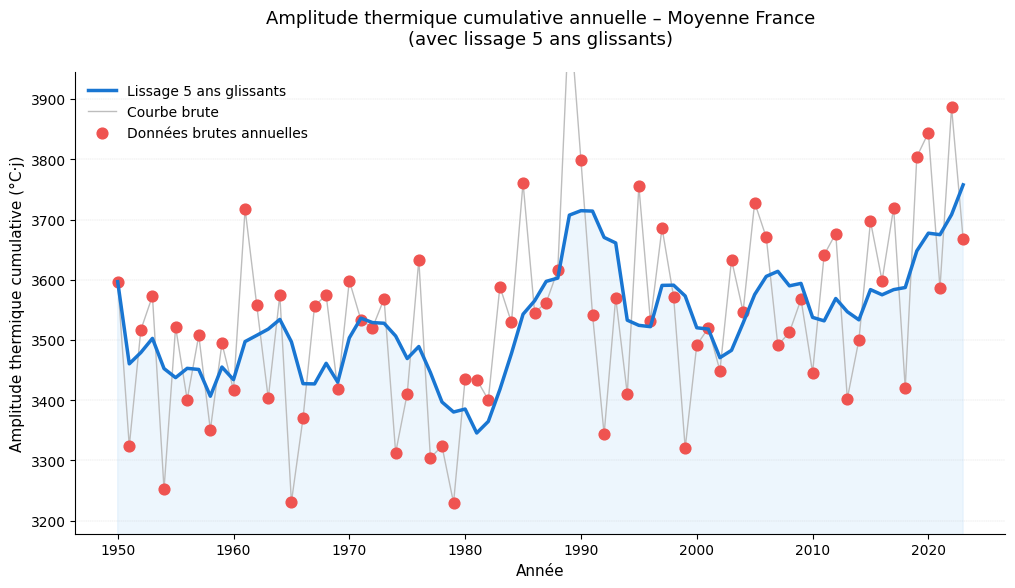

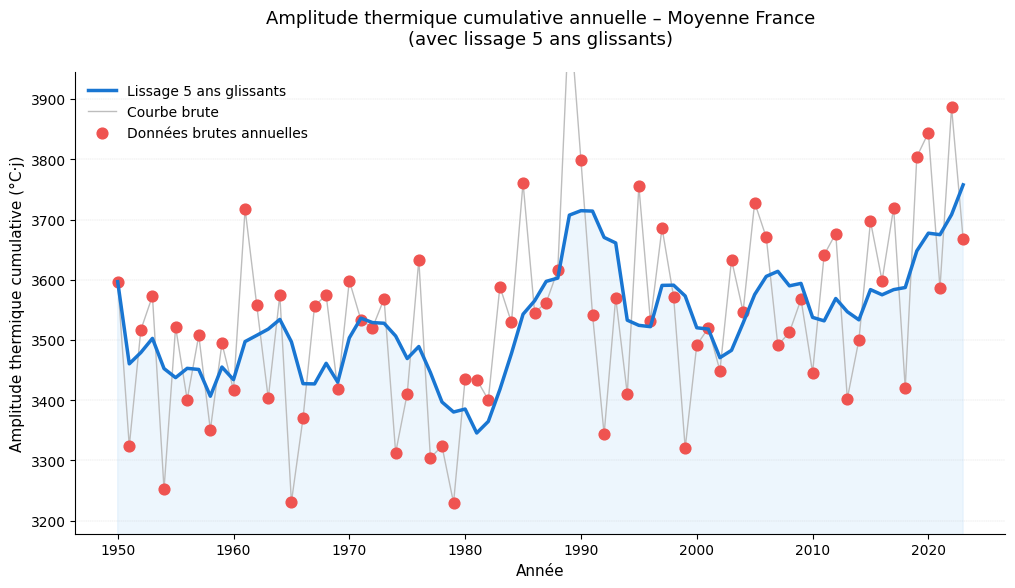

In [4]:
import pandas as pd
import duckdb as ddb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df['AAAAMMJJ'] = pd.to_datetime(df['AAAAMMJJ'].astype(str), format='%Y%m%d')
df['year'] = df['AAAAMMJJ'].dt.year
df = df.sort_values('year')

df_annual = df.groupby('year')['cumulative_amplitude'].max().reset_index()
df_annual['smoothed'] = df_annual['cumulative_amplitude'].rolling(window=5, min_periods=1).mean()

plt.rcParams['font.family'] = 'DejaVu Sans'
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(df_annual['year'], df_annual['cumulative_amplitude'],
           color='#EF5350', s=60, zorder=3, label='Données brutes annuelles')
ax.plot(df_annual['year'], df_annual['cumulative_amplitude'],
        color='#BDBDBD', linewidth=1, label='Courbe brute', zorder=2)
ax.plot(df_annual['year'], df_annual['smoothed'],
        color='#1976D2', linewidth=2.5, label='Lissage 5 ans glissants', zorder=4)
ax.fill_between(df_annual['year'],
                df_annual['smoothed'],
                alpha=0.25,
                color='#BBDEFB',
                zorder=1)

ax.set_xlabel('Année', fontsize=11)
ax.set_ylabel('Amplitude thermique cumulative (°C·j)', fontsize=11)
ax.set_title('Amplitude thermique cumulative annuelle – Moyenne France\n(avec lissage 5 ans glissants)',
             fontsize=13, pad=20)
ax.grid(which='major', axis='y', linestyle='--', linewidth=0.25, alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(bottom=df_annual['smoothed'].min()*0.95,
            top=df_annual['smoothed'].max()*1.05)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon=False, loc='upper left', fontsize=10)

dataviz = fig
dataviz

---
*Made with ❤️ and with [duckit.fr](https://duckit.fr) - [Ali Hmaou](https://www.linkedin.com/in/ali-hmaou-6b7b73146/)*

In [5]:

# --- Variables injectées par le script ---
FINAL_OBJECT_VARIABLE_NAME = 'dataviz'
OUTPUT_IMAGE_NAME = 'published\\notebooks\\duckit_analysis_20250820_225736.png'
OUTPUT_HTML_NAME = 'published\\notebooks\\duckit_analysis_20250820_225736.html'

# ===================================================================
# CELLULE INJECTÉE AUTOMATIQUEMENT (VERSION ROBUSTE)
# ===================================================================
import sys
import os
# On importe les modules nécessaires pour l'export au cas où
try:
    from bokeh.io import save as bokeh_save
except ImportError:
    bokeh_save = None

try:
    # On s'assure que le dossier de sortie existe
    output_dir = os.path.dirname(OUTPUT_IMAGE_NAME)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    # On utilise globals().get() pour une récupération plus sûre
    final_object = globals().get(FINAL_OBJECT_VARIABLE_NAME)

    if final_object is None:
        # On lève une NameError pour être cohérent avec le code original
        raise NameError(f"name '{FINAL_OBJECT_VARIABLE_NAME}' is not defined")

    print(f"INFO: Variable '{FINAL_OBJECT_VARIABLE_NAME}' trouvée. Tentative d'exportation...")

    object_type = str(type(final_object))

    if 'plotly.graph_objs._figure.Figure' in object_type:
        print(f"--> Détecté : Plotly. Sauvegarde HTML et PNG.")
        # 1. Sauvegarde HTML pour l'interactivité
        print(f"--> Sauvegarde HTML dans : {OUTPUT_HTML_NAME}")
        final_object.write_html(OUTPUT_HTML_NAME, include_plotlyjs='cdn')
        # 2. Sauvegarde PNG pour l'aperçu statique
        try:
            print(f"--> Tentative de sauvegarde PNG directe dans : {OUTPUT_IMAGE_NAME}")
            final_object.write_image(OUTPUT_IMAGE_NAME, scale=3, width=1200, height=800)
            print(f"--> Image Plotly sauvegardée avec succès.")
        except Exception as e:
            print(f"AVERTISSEMENT: La sauvegarde directe en PNG a échoué (kaleido est-il installé?).", file=sys.stderr)
            print(f"   Erreur: {e}", file=sys.stderr)
            print(f"--> PLAN B: On va utiliser la capture d'écran du HTML à la place.")
            # On crée un fichier marqueur pour que le script de post-traitement prenne le relais
            with open(f"{OUTPUT_HTML_NAME}.needs_screenshot", "w") as f:
                f.write("plotly")
    elif 'folium.folium.Map' in object_type:
        print(f"--> Détecté : Folium. Sauvegarde HTML dans : {OUTPUT_HTML_NAME}")
        final_object.save(OUTPUT_HTML_NAME)
        # On crée un fichier marqueur générique pour la capture d'écran
        print(f"--> Création du marqueur de capture d'écran.")
        with open(f"{OUTPUT_HTML_NAME}.needs_screenshot", "w") as f:
            f.write("folium")
    elif 'altair.vegalite' in object_type and hasattr(final_object, 'save'):
        print(f"--> Détecté : Altair. Sauvegarde HTML dans : {OUTPUT_HTML_NAME}")
        final_object.save(OUTPUT_HTML_NAME)
        # On crée un fichier marqueur générique pour la capture d'écran
        print(f"--> Création du marqueur de capture d'écran.")
        with open(f"{OUTPUT_HTML_NAME}.needs_screenshot", "w") as f:
            f.write("altair")
    elif 'bokeh.plotting' in object_type and bokeh_save is not None:
        print(f"--> Détecté : Bokeh. Sauvegarde HTML dans : {OUTPUT_HTML_NAME}")
        bokeh_save(final_object, filename=OUTPUT_HTML_NAME, title="")
        # On crée un fichier marqueur générique pour la capture d'écran
        print(f"--> Création du marqueur de capture d'écran.")
        with open(f"{OUTPUT_HTML_NAME}.needs_screenshot", "w") as f:
            f.write("bokeh")
    elif 'matplotlib.figure.Figure' in object_type:
        print(f"--> Détecté : Matplotlib. Sauvegarde dans : {OUTPUT_IMAGE_NAME}")
        final_object.savefig(OUTPUT_IMAGE_NAME, dpi=300, bbox_inches='tight')
    else:
        print(f"AVERTISSEMENT: Type non supporté : {object_type}", file=sys.stderr)
except NameError:
    print(f"AVERTISSEMENT: Aucune variable '{FINAL_OBJECT_VARIABLE_NAME}' trouvée.", file=sys.stderr)
except Exception as e:
    print(f"ERREUR lors de l'exportation : {e}", file=sys.stderr)


INFO: Variable 'dataviz' trouvée. Tentative d'exportation...
--> Détecté : Matplotlib. Sauvegarde dans : published\notebooks\duckit_analysis_20250820_225736.png
